In [1]:
import os
os.chdir('molanalysis')

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing pairwise anatomical distance for each session: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]
Setting outlier RFs to NaN: 100%|██████████| 1/1 [00:00<00:00, 197.05it/s]


Index(['iscell', 'iscell_prob', 'skew', 'radius', 'npix_soma', 'npix', 'xloc', 'yloc', 'redcell', 'frac_of_ROI_red', 'frac_red_in_ROI', 'chan2_prob', 'nredcells', 'plane_idx', 'roi_idx', 'plane_in_roi_idx', 'roi_name', 'depth', 'power_mw', 'labeled', 'arealabel', 'rf_az_F', 'rf_el_F', 'rf_sx_F', 'rf_sy_F', 'rf_r2_F', 'rf_az_Fneu', 'rf_el_Fneu', 'rf_sx_Fneu', 'rf_sy_Fneu', 'rf_r2_Fneu', 'rf_az_Fsmooth', 'rf_el_Fsmooth', 'rf_sx_Fsmooth', 'rf_sy_Fsmooth', 'rf_r2_Fsmooth', 'meanF', 'meanF_chan2', 'noise_level', 'event_rate', 'cell_id', 'layer', 'recombinase', 'session_id', 'rf_az_Ftwin',
       'rf_el_Ftwin', 'rf_az_Ftwin_0', 'rf_el_Ftwin_0', 'rf_az_Ftwin_1', 'rf_el_Ftwin_1', 'rf_az_Ftwin_2', 'rf_el_Ftwin_2', 'rf_az_Ftwin_3', 'rf_el_Ftwin_3', 'rf_az_Ftwin_4', 'rf_el_Ftwin_4', 'rf_r2_Ftwin'],
      dtype='object')


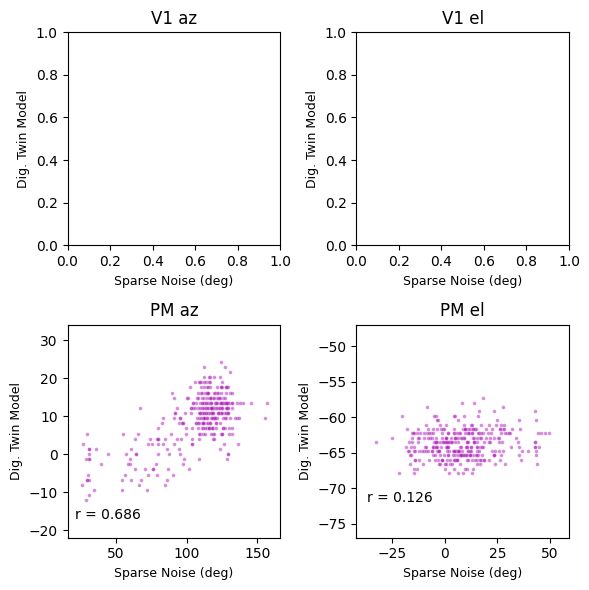

In [26]:
# -*- coding: utf-8 -*-
"""
This script analyzes neural and behavioral data in a multi-area calcium imaging
dataset with labeled projection neurons. The visual stimuli are natural images.
Matthijs Oude Lohuis, 2023, Champalimaud Center
""" 

#%% Imports
# Import general libs
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Set working directory to root of repo
current_path = os.getcwd()
# Identify if path has 'molanalysis' as a folder in it
if 'molanalysis' in current_path:
    # If so, set the path to the root of the repo
    current_path = current_path.split('molanalysis')[0] + 'molanalysis'
else:
    raise FileNotFoundError(
        f'This needs to be run somewhere from within the molanalysis folder, not {current_path}')
os.chdir(current_path)
sys.path.append(current_path)

from naturalimages.sensorium_utility_training_read_config import read_config

run_config = read_config('../Petreanu_MEI_generation/run_config.yaml') # Must be set

RUN_NAME = run_config['RUN_NAME'] # MUST be set. Creates a subfolder in the runs folder with this name, containing data, saved models, etc. IMPORTANT: all values in this folder WILL be deleted.

keep_behavioral_info = run_config['data']['keep_behavioral_info']
area_of_interest = run_config['data']['area_of_interest']
sessions_to_keep = run_config['data']['sessions_to_keep']
OUTPUT_NAME = run_config['data']['OUTPUT_NAME']
INPUT_FOLDER = run_config['data']['INPUT_FOLDER']
OUTPUT_FOLDER = f'../molanalysis/MEI_generation/data/{OUTPUT_NAME}' # relative to molanalysis root folder

# os.chdir('../')  # set working directory to the root of the git repo

# Import personal lib funcs
from loaddata.session_info import load_sessions
from utils.plotting_style import *  # get all the fixed color schemes
from utils.imagelib import load_natural_images
from loaddata.get_data_folder import get_local_drive
from utils.pair_lib import compute_pairwise_anatomical_distance
from utils.rf_lib import *

savedir = os.path.join(f'../Petreanu_MEI_generation/runs/{RUN_NAME}/Plots/RF_analysis')
os.makedirs(savedir, exist_ok=True)

# %% Load IM session with receptive field mapping ################################################

# test if folders already defined 
try: 
    folders
except NameError:
    # First level
    folders = [os.path.join(INPUT_FOLDER, name) for name in os.listdir(
        INPUT_FOLDER) if os.path.isdir(os.path.join(INPUT_FOLDER, name)) and not "merged_data" in name]
    folders = [x.replace("\\", "/") for x in folders]
    # Second level
    files = [[folder, os.path.join(folder, name).replace('\\', '/')] for folder in folders for name in os.listdir(
        folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
    # only get last value after /
    session_list = [[folder.split("/")[-1], name.split("/")[-1]]
                    for folder, name in files]

    # drop ['LPE10919', '2023_11_08'] because the data is not converted yet
    session_list = [x for x in session_list if x != ['LPE10919', '2023_11_08']]
    print(session_list)

if sessions_to_keep != 'all':
    session_list = [x for x in session_list if x in sessions_to_keep]


session_list = np.array([['LPE10885', '2023_10_20']])
# Load sessions lazy: (no calciumdata, behaviordata etc.,)
sessions, nSessions = load_sessions(protocol='IM', session_list=session_list, data_folder = INPUT_FOLDER)

#%% 
for ises in range(nSessions):    # Load proper data and compute average trial responses:
    sessions[ises].load_respmat(calciumversion='deconv', keepraw=False)

#%% Interpolation of receptive fields:
sessions = compute_pairwise_anatomical_distance(sessions)
sessions = smooth_rf(sessions,radius=75,rf_type='Fneu')
sessions = exclude_outlier_rf(sessions) 
sessions = replace_smooth_with_Fsig(sessions) 

#%% Load the output of digital twin model:
if area_of_interest == 'V1':
    statsfile_V1        = f'../Petreanu_MEI_generation/runs/{RUN_NAME}/results/neuron_stats.csv'
    statsdata_V1        = pd.read_csv(statsfile_V1)	
elif area_of_interest == 'PM':
    statsfile_PM        = f'../Petreanu_MEI_generation/runs/{RUN_NAME}/results/neuron_stats.csv'
    statsdata_PM        = pd.read_csv(statsfile_PM)

try:
    statsdata_V1        = pd.read_csv(statsfile_V1)	
except:
    statsdata_V1        = pd.DataFrame(columns=['cell_id', 'loc', 'loc_0', 'loc_1', 'loc_2', 'loc_3', 'loc_4'])

try:
    statsdata_PM        = pd.read_csv(statsfile_PM)
except:
    statsdata_PM        = pd.DataFrame(columns=['cell_id', 'loc', 'loc_0', 'loc_1', 'loc_2', 'loc_3', 'loc_4'])

ises                = 0
statsdata           = pd.concat([statsdata_V1,statsdata_PM]).reset_index(drop=True)

def replace_str(x):
    return x.replace('   ',' ').replace('  ',' ').replace('[ ','').replace(' ]','').replace('[','').replace(']','').split(' ')

loc_columns = ['loc', 'loc_0', 'loc_1', 'loc_2', 'loc_3', 'loc_4']
g = statsdata[loc_columns].applymap(lambda x: replace_str(x))

mergedata = pd.DataFrame(np.array(g['loc'].values.tolist(), dtype=float), columns=['rf_az_Ftwin', 'rf_el_Ftwin',])
for i in range(5):
    temp_df = pd.DataFrame(np.array(g[f'loc_{i}'].values.tolist(), dtype=float), columns=[f'rf_az_Ftwin_{i}', f'rf_el_Ftwin_{i}'])
    mergedata = pd.concat([mergedata, temp_df], axis=1)

mergedata['cell_id'] = statsdata['cell_id']
sessions[ises].celldata = sessions[ises].celldata.merge(mergedata, on='cell_id')
sessions[ises].celldata['rf_r2_Ftwin'] = 0
sessions[ises].celldata['rf_az_Ftwin'] = (sessions[ises].celldata['rf_az_Ftwin']+0.5)*135
sessions[ises].celldata['rf_el_Ftwin'] = (sessions[ises].celldata['rf_el_Ftwin']+0.5)*62 - 53
for i in range(5):
    sessions[ises].celldata[f'rf_az_Ftwin_{i}'] = (sessions[ises].celldata[f'rf_az_Ftwin_{i}'] + 0.5) * 135
    sessions[ises].celldata[f'rf_el_Ftwin_{i}'] = (sessions[ises].celldata[f'rf_el_Ftwin_{i}'] + 0.5) * 62 - 53
# sessions[ises].celldata['rf_el_Ftwin'] = (sessions[ises].celldata['rf_el_Ftwin']+0.5)*62 - 16.7

# #%% Load the output of digital twin model:
# statsfile       = 'E:\\Procdata\\IM\\LPE10885\\2023_10_20\\LPE10885_2023_10_20_neuron_stats.csv'
# statsdata       = pd.read_csv(statsfile)

# g               = statsdata['loc'].apply(lambda x: x.replace('[ ','').replace(' ]','').replace('   ',' ').replace('  ',' ').replace('[','').replace(']','').split(' '))
# g               = np.array(list(g), dtype=float)

# mergedata       = pd.DataFrame(data=g,columns=['rf_az_Ftwin','rf_el_Ftwin'])
# mergedata['cell_id'] = statsdata['cell_id']
# sessions[ises].celldata = sessions[ises].celldata.merge(mergedata, on='cell_id')
# sessions[ises].celldata['rf_r2_Ftwin'] = 0
# sessions[ises].celldata['rf_az_Ftwin'] = (sessions[ises].celldata['rf_az_Ftwin']+0.5)*135
# sessions[ises].celldata['rf_el_Ftwin'] = (sessions[ises].celldata['rf_el_Ftwin']+0.5)*62 - 53

#%% Make a ascatter of azimuth estimated through rf mapping and by linear model of average triggered image:
areas       = ['V1', 'PM']
spat_dims   = ['az', 'el']
clrs_areas  = get_clr_areas(areas)
# sig_thr     = 0.001
# sig_thr     = 0.05
# sig_thr     = 0.001
# r2_thr      = 0.5
r2_thr       = np.inf
rf_type      = 'F'
# rf_type      = 'Fneu'
rf_type_twin = 'Ftwin'
fig,axes     = plt.subplots(2,2,figsize=(6,6))
print(sessions[0].celldata.columns)
for iarea,area in enumerate(areas):
    for ispat_dim,spat_dim in enumerate(spat_dims):
        idx         = (sessions[0].celldata['roi_name'] == area) & (sessions[0].celldata['rf_r2_' + rf_type] < r2_thr)
        x = sessions[0].celldata[f'rf_{spat_dim}_{rf_type}'][idx]
        y = sessions[0].celldata[f'rf_{spat_dim}_{rf_type_twin}'][idx]

        sns.scatterplot(ax=axes[iarea,ispat_dim],x=x,y=y,s=7,c=clrs_areas[iarea],alpha=0.5)
        axes[iarea,ispat_dim].set_title(f'{area} {spat_dim}',fontsize=12)
        axes[iarea,ispat_dim].set_xlabel('Sparse Noise (deg)',fontsize=9)
        axes[iarea,ispat_dim].set_ylabel(f'Dig. Twin Model',fontsize=9)
        # if spat_dim == 'az':
        #     axes[iarea,ispat_dim].set_xlim([-50,135])
        #     axes[iarea,ispat_dim].set_ylim([-50,135])
        #     # axes[iarea,ispat_dim].set_ylim([-0.5,0.5])
        # elif spat_dim == 'el':
        #     axes[iarea,ispat_dim].set_xlim([-150.2,150.2])
        #     axes[iarea,ispat_dim].set_ylim([-150.2,150.2])
            # axes[iarea,ispat_dim].set_ylim([-0.5,0.5])
        idx = (~np.isnan(x)) & (~np.isnan(y))
        x =  x[idx]
        y =  y[idx]
        # print(f'x min: {min(x) if len(x) > 0 else "None"}')
        # print(f'x max: {max(x) if len(x) > 0 else "None"}')
        # print(f'y min: {min(y) if len(y) > 0 else "None"}')
        # print(f'y max: {max(y) if len(y) > 0 else "None"}')
        if len(x) > 0:
            axes[iarea,ispat_dim].set_xlim([int(min(x) - 10), int(max(x) + 10)])
        if len(y) > 0:
            axes[iarea,ispat_dim].set_ylim([int(min(y) - 10), int(max(y) + 10)])
        # axes[iarea,ispat_dim].text(x=0,y=0.1,s='r = ' + str(np.round(np.corrcoef(x,y)[0,1],3),))
        if len(x) > 0 and len(y) > 0:
            axes[iarea,ispat_dim].text(x=int(min(x) - 5),y=int(min(y) - 5),s='r = ' + str(np.round(np.corrcoef(x,y)[0,1],3),))
plt.tight_layout()
fig.savefig(os.path.join(savedir, f'Alignment_TwinGaussLoc_RF_{rf_type}_{sessions[0].sessiondata["session_id"][0]}.png'), format='png')

In [17]:
idx         = (sessions[0].celldata['roi_name'] == area) & (sessions[0].celldata['rf_r2_' + rf_type] < r2_thr)
x = sessions[0].celldata[f'rf_{spat_dim}_{rf_type}'][idx]
y = sessions[0].celldata[f'rf_{spat_dim}_{rf_type_twin}'][idx]

In [18]:
['rf_r2_' + rf_type]

['rf_r2_Fneu']

In [21]:
(sessions[0].celldata['roi_name'] == area)

0       True
1       True
2       True
3       True
4       True
        ... 
1168    True
1169    True
1170    True
1171    True
1172    True
Name: roi_name, Length: 1173, dtype: bool

In [23]:
r2_thr

-inf

In [22]:
sessions[0].celldata['rf_r2_' + rf_type] < r2_thr

0       False
1       False
2       False
3       False
4       False
        ...  
1168    False
1169    False
1170    False
1171    False
1172    False
Name: rf_r2_Fneu, Length: 1173, dtype: bool

In [20]:
idx

0       False
1       False
2       False
3       False
4       False
        ...  
1168    False
1169    False
1170    False
1171    False
1172    False
Length: 1173, dtype: bool

In [12]:
pd.set_option('display.max_columns', 500)

In [13]:
sessions[0].celldata

,iscell,iscell_prob,skew,radius,npix_soma,npix,xloc,yloc,redcell,frac_of_ROI_red,frac_red_in_ROI,chan2_prob,nredcells,plane_idx,roi_idx,plane_in_roi_idx,roi_name,depth,power_mw,labeled,arealabel,rf_az_F,rf_el_F,rf_sx_F,rf_sy_F,rf_r2_F,rf_az_Fneu,rf_el_Fneu,rf_sx_Fneu,rf_sy_Fneu,rf_r2_Fneu,rf_az_Fsmooth,rf_el_Fsmooth,rf_sx_Fsmooth,rf_sy_Fsmooth,rf_r2_Fsmooth,meanF,meanF_chan2,noise_level,event_rate,cell_id,layer,recombinase,session_id,rf_az_Ftwin,rf_el_Ftwin,rf_az_Ftwin_0,rf_el_Ftwin_0,rf_az_Ftwin_1,rf_el_Ftwin_1,rf_az_Ftwin_2,rf_el_Ftwin_2,rf_az_Ftwin_3,rf_el_Ftwin_3,rf_az_Ftwin_4,rf_el_Ftwin_4,rf_r2_Ftwin
0,1.0,0.967153,5.268604,6.838876,167.0,383.0,254.0,429.0,0.0,0.0,0.0,0.432050,71,0,0,0,PM,140.0,40.000000,unl,PMunl,NaN,NaN,NaN,NaN,NaN,125.212588,1.027514,10.721651,15.919710,0.200176,122.370214,3.240301,NaN,NaN,1.000000,1430.47330,8.595869,3.213844,0.030171,LPE10885_2023_10_20_0_0000,L2/3,non,LPE10885_2023_10_20,12.15,-59.20,-63.45,-84.00,-64.80,-75.94,-52.65,-82.14,128.25,-49.90,109.35,-4.02,0
1,1.0,0.996898,7.369462,7.338488,141.0,190.0,406.0,49.0,0.0,0.0,0.0,0.377845,71,0,0,0,PM,140.0,40.000000,unl,PMunl,NaN,NaN,NaN,NaN,NaN,29.943877,0.143432,7.194740,8.795468,0.154864,61.604024,2.631376,NaN,NaN,1.000000,1049.48970,126.043760,4.682066,0.025547,LPE10885_2023_10_20_0_0001,L2/3,non,LPE10885_2023_10_20,-6.75,-65.40,-82.35,-90.82,-74.25,-87.10,-67.50,-90.20,148.50,-60.44,41.85,1.56,0
2,1.0,0.989760,3.229899,5.819851,125.0,150.0,490.0,57.0,0.0,0.0,0.0,0.406527,71,0,0,0,PM,140.0,40.000000,unl,PMunl,NaN,NaN,NaN,NaN,NaN,0.496038,64.306948,5.459898,26.779544,0.074510,61.678147,3.141075,NaN,NaN,1.000000,1512.72100,37.139100,4.869548,0.041616,LPE10885_2023_10_20_0_0002,L2/3,non,LPE10885_2023_10_20,5.40,-64.16,-71.55,-84.62,-51.30,-86.48,-68.85,-85.86,160.65,-62.92,62.10,-0.30,0
3,1.0,0.991979,7.171705,5.773342,117.0,145.0,210.0,29.0,0.0,0.0,0.0,0.410785,71,0,0,0,PM,140.0,40.000000,unl,PMunl,NaN,NaN,NaN,NaN,NaN,63.166591,-14.699918,7.526037,1.657322,0.056042,100.799828,2.904467,NaN,NaN,1.000000,1430.11660,12.677818,4.173919,0.025316,LPE10885_2023_10_20_0_0003,L2/3,non,LPE10885_2023_10_20,14.85,-64.16,-64.80,-90.82,-52.65,-75.94,-60.75,-79.66,159.30,-67.26,90.45,-7.12,0
4,1.0,0.980091,7.256192,6.157345,133.0,176.0,262.0,449.0,0.0,0.0,0.0,0.285240,71,0,0,0,PM,140.0,40.000000,unl,PMunl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.681964,2.597889,NaN,NaN,1.000000,1137.68020,3.178514,4.561978,0.039188,LPE10885_2023_10_20_0_0004,L2/3,non,LPE10885_2023_10_20,18.90,-62.30,-52.65,-88.96,-49.95,-75.32,-55.35,-87.72,130.95,-56.72,118.80,-4.02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,1.0,0.920875,0.889110,5.487384,79.0,93.0,465.0,128.0,0.0,0.0,0.0,0.440209,51,3,0,3,PM,258.0,67.580799,unl,PMunl,NaN,NaN,NaN,NaN,NaN,31.788925,-2.962207,6.852005,10.614989,0.098234,74.585243,4.385799,NaN,NaN,1.000000,1118.88510,280.210700,7.532934,0.114096,LPE10885_2023_10_20_3_0339,L4,non,LPE10885_2023_10_20,-10.80,-62.30,-76.95,-87.72,-79.65,-82.14,-82.35,-90.20,139.05,-51.76,43.20,0.94,0
1169,1.0,0.622431,1.244387,4.368339,64.0,79.0,139.0,344.0,0.0,0.0,0.0,-0.000285,51,3,0,3,PM,258.0,67.580799,unl,PMunl,NaN,NaN,NaN,NaN,NaN,126.773707,20.999648,12.017793,12.226712,0.339856,123.633226,17.295405,NaN,NaN,1.000000,765.28680,-3.083832,8.239972,0.109935,LPE10885_2023_10_20_3_0344,L4,non,LPE10885_2023_10_20,1.35,-57.34,-82.35,-77.18,-76.95,-73.46,-74.25,-87.72,135.00,-51.14,102.60,2.18,0
1170,1.0,0.684631,1.711489,6.102885,70.0,77.0,201.0,296.0,0.0,0.0,0.0,0.444665,51,3,0,3,PM,258.0,67.580799,unl,PMunl,NaN,NaN,NaN,NaN,NaN,58.041783,-14.907681,5.837798,1.708052,0.042895,121.172081,2.967093,NaN,NaN,1.000000,930.40106,8.175797,8.625743,0.105426,LPE10885_2023_10_20_3_0346,L4,non,LPE10885_2023_10_20,2.70,-62.30,-70.20,-79.04,-78.30,-81.52,-82.35,-87.72,133.65,-61.68,112.05,-0.30,0
1

In [8]:
sessions[0].celldata['rf_r2_' + rf_type] < r2_thr

0       False
1       False
2       False
3       False
4       False
        ...  
1168    False
1169    False
1170    False
1171    False
1172    False
Name: rf_r2_F, Length: 1173, dtype: bool

In [6]:
idx

0       False
1       False
2       False
3       False
4       False
        ...  
1168    False
1169    False
1170    False
1171    False
1172    False
Length: 1173, dtype: bool

In [14]:
celldata[idx]

,iscell,iscell_prob,skew,radius,npix_soma,npix,xloc,...,rf_az_Ftwin_2,rf_el_Ftwin_2,rf_az_Ftwin_3,rf_el_Ftwin_3,rf_az_Ftwin_4,rf_el_Ftwin_4,rf_r2_Ftwin
0,1.0,0.967153,5.268604,6.838876,167.0,383.0,254.0,...,-67.5,-80.90,143.10,-57.34,110.70,-4.64,0
1,1.0,0.996898,7.369462,7.338488,141.0,190.0,406.0,...,-67.5,-83.38,152.55,-59.20,56.70,-5.26,0
2,1.0,0.989760,3.229899,5.819851,125.0,150.0,490.0,...,-67.5,-83.38,152.55,-59.20,48.60,-5.26,0
3,1.0,0.991979,7.171705,5.773342,117.0,145.0,210.0,...,-67.5,-84.00,155.25,-60.44,83.70,-6.50,0
4,1.0,0.980091,7.256192,6.157345,133.0,176.0,262.0,...,-67.5,-80.90,143.10,-56.72,110.70,-4.64,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,1.0,0.920875,0.889110,5.487384,79.0,93.0,465.0,...,-67.5,-83.38,148.50,-58.58,58.05,-5.26,0
1169,1.0,0.622431,1.244387,4.368339,64.0,79.0,139.0,...,-67.5,-80.90,147.15,-57.96,110.70,-4.64,0
1170,1.0,0.684631,1.711489,6.102885,70.0,77.0,201.0,...,-67.5,-80.90,147.15,-57.96,110.70,-4.64,0
1171,1.0,0.976950,2.105739,6.052476,79.0,93.0,493.0,...,-67.5,-83.38,152.55,-59.82,44.55,-5.26,0


In [15]:
celldata[idx].columns

Index(['iscell', 'iscell_prob', 'skew', 'radius', 'npix_soma', 'npix', 'xloc', 'yloc', 'redcell', 'frac_of_ROI_red', 'frac_red_in_ROI', 'chan2_prob', 'nredcells', 'plane_idx', 'roi_idx', 'plane_in_roi_idx', 'roi_name', 'depth', 'power_mw', 'labeled', 'arealabel', 'rf_az_F', 'rf_el_F', 'rf_sx_F', 'rf_sy_F', 'rf_r2_F', 'rf_az_Fneu', 'rf_el_Fneu', 'rf_sx_Fneu', 'rf_sy_Fneu', 'rf_r2_Fneu', 'rf_az_Fsmooth', 'rf_el_Fsmooth', 'rf_sx_Fsmooth', 'rf_sy_Fsmooth', 'rf_r2_Fsmooth', 'meanF', 'meanF_chan2', 'noise_level', 'event_rate', 'cell_id', 'layer', 'recombinase', 'session_id', 'rf_az_Ftwin',
       'rf_el_Ftwin', 'rf_az_Ftwin_0', 'rf_el_Ftwin_0', 'rf_az_Ftwin_1', 'rf_el_Ftwin_1', 'rf_az_Ftwin_2', 'rf_el_Ftwin_2', 'rf_az_Ftwin_3', 'rf_el_Ftwin_3', 'rf_az_Ftwin_4', 'rf_el_Ftwin_4', 'rf_r2_Ftwin'],
      dtype='object')

In [11]:
sns.scatterplot(data = celldata[idx],x='yloc',y='xloc',hue_norm=(-16.7,50.2),
                                hue=vars[i],ax=axes[i,j],palette='gist_rainbow',size=9,edgecolor="none")
plt.show()

C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_11640\2387018675.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = celldata[idx],x='yloc',y='xloc',hue_norm=(-16.7,50.2),


In [6]:
idx_area    = celldata['roi_name']==areas[j]
# idx_sig     = celldata['rf_r2_' + rf_type] > r2_thr
idx_sig     = celldata[vars[i]] > r2_thr
idx         = np.logical_and(idx_area,idx_sig)

0       False
1       False
2       False
3       False
4       False
        ...  
1168    False
1169    False
1170    False
1171    False
1172    False
Length: 1173, dtype: bool

In [7]:
celldata['roi_name']==areas[j]

0       True
1       True
2       True
3       True
4       True
        ... 
1168    True
1169    True
1170    True
1171    True
1172    True
Name: roi_name, Length: 1173, dtype: bool

In [8]:
celldata[vars[i]] > r2_thr

0       False
1       False
2       False
3       False
4       False
        ...  
1168    False
1169    False
1170    False
1171    False
1172    False
Name: rf_el_Ftwin, Length: 1173, dtype: bool

In [9]:
celldata[vars[i]]

0      -61.68
1      -62.92
2      -62.92
3      -63.54
4      -61.68
        ...  
1168   -62.92
1169   -61.68
1170   -61.68
1171   -62.92
1172   -63.54
Name: rf_el_Ftwin, Length: 1173, dtype: float64